# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. You will prepare a small report for them.

The hourly demand information would be useful in planning the number of bikes that need to be available in the system on any given hour of the day, and also in monitoring traffic in the city. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on attributes about the hour and the day. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will add some features that will help us with the analysis and then separate it into training and test sets. Each row in this file contains 12 attributes and each entry represents one hour of a 24-hour day with its weather, etc, and the number of rental rides for that day divided in categories according to if they were made by registered or casual riders. Those attributes are the following:

- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Explore how Bike Ridership varies with Hour of the Day </b> </div>

#### Learn your Domain and Perform a bit of Feature Engineering

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011 and 1 for 2012.
- `month` with 1 through 12, with 1 denoting Jan. 
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

**1.4** Use visualization to inspect and comment on how **casual** rentals and **registered** rentals vary with the `hour`. 

**1.5** Use the variable `holiday` to show how **holidays** affect the relationship in question 1.4.  What do you observe? 

**1.6** Use visualization to show how **weather** affects **casual** and **registered** rentals. What do you observe? 

### Answers

#### 1.1 Load the dataset from the csv file  ...

In [3]:
# your code here
'''
Load the dataset from the csv file data/BSS_hour_raw.csv into a pandas dataframe that you name bikes_df. 
Do any of the variables' ranges or averages seem suspect? 
Do the data types make sense?
'''
bikes_df = pd.read_csv("data/BSS_hour_raw.csv")
bikes_df.describe()


,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


<HR>
    The temp and atemp variables seem suspect. Since they are temperatures in celsius, the range of 0 to 1 does not really make sense. It seems to be normalized with respect to some values.
<HR>

In [4]:
bikes_df.dtypes

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object

<HR>
    The datatypes seem fine, except for the dteday column which is an object. 
<HR>

#### 1.2 Notice that the variable in column ....

In [5]:
# your code here
bikes_df['dteday'] = pd.to_datetime(bikes_df['dteday'])
bikes_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

#### 1.3 Create three new columns ...

In [6]:
# your code here
bikes_df['month'] = bikes_df['dteday'].dt.month
bikes_df['year'] = np.where(bikes_df['dteday'].dt.year==2011, 0, 1)
bikes_df['counts'] = bikes_df['casual'] + bikes_df['registered']
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,month,year,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,1,0,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,1,0,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,1,0,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,1,0,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,0,1


#### 1.4 Use visualization to inspect and comment on how casual rentals and registered rentals vary with the hour. 

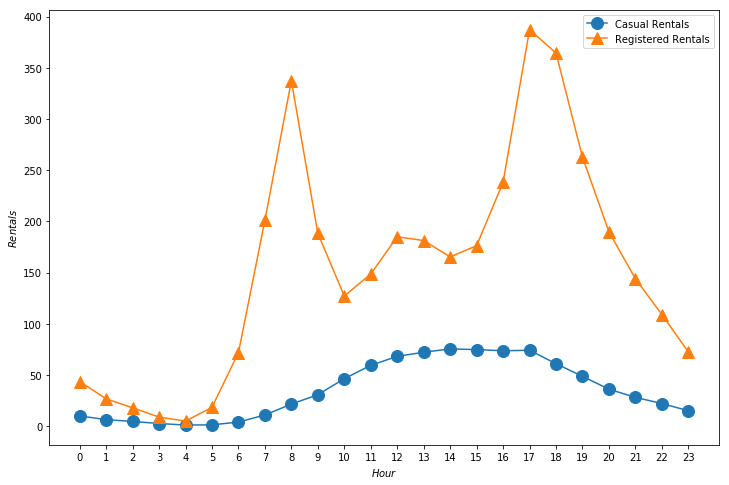

In [7]:
# your code here
bikes_df_hourly = bikes_df.groupby('hour').agg({
    'casual': np.mean,
    'registered':np.mean
})

fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(bikes_df_hourly.index, bikes_df_hourly['casual'], 'o-', ms=12, label="Casual Rentals")
ax.plot(bikes_df_hourly.index, bikes_df_hourly['registered'],'^-', ms=12, label="Registered Rentals")
ax.set_xlabel(r'$Hour$')
ax.set_ylabel(r'$Rentals$')
ax.set_xticks(np.arange(0, 24, 1))
ax.legend();

<HR>Casual rentals gradually rise in the morning, peak in the late afternoon and drop thereafter.
    
Registered rentals have a more variable pattern with high reservations at peak hours in the morning and evening and high usage at around lunch time.
<HR>

#### 1.5 Use the variable holiday to show how holidays affect the relationship in question 1.4. What do you observe?

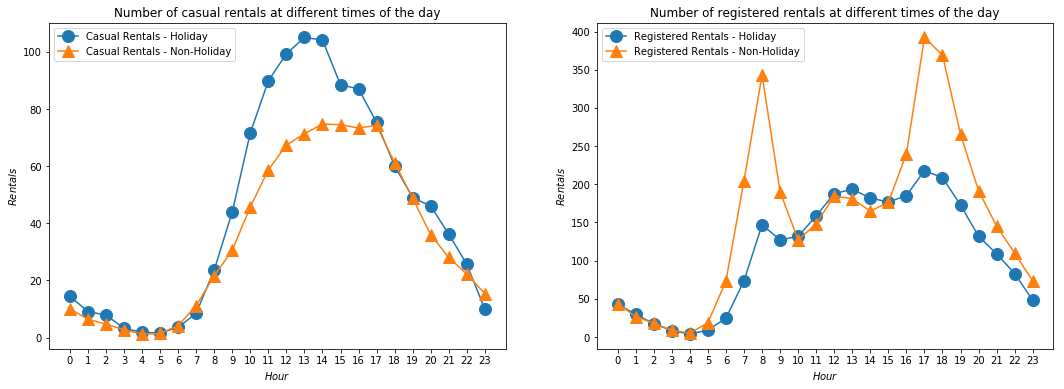

In [8]:
# your code here
holiday_df = bikes_df[bikes_df['holiday']==1]
non_holiday_df = bikes_df[bikes_df['holiday']==0]

holiday_df_hourly = holiday_df.groupby('hour').agg({
    'casual': np.mean,
    'registered':np.mean
})
non_holiday_df_hourly = non_holiday_df.groupby('hour').agg({
    'casual': np.mean,
    'registered':np.mean
})

fig, ax = plt.subplots(1,2, figsize=(18,6))

ax[0].plot(holiday_df_hourly.index, holiday_df_hourly['casual'], 'o-', ms=12, label="Casual Rentals - Holiday")
ax[0].plot(non_holiday_df_hourly.index, non_holiday_df_hourly['casual'],'^-', ms=12, label="Casual Rentals - Non-Holiday")
ax[0].set_xlabel(r'$Hour$')
ax[0].set_ylabel(r'$Rentals$')
ax[0].set_xticks(np.arange(0, 24, 1))
ax[0].set_title(r'Number of casual rentals at different times of the day')
ax[0].legend();

ax[1].plot(holiday_df_hourly.index, holiday_df_hourly['registered'], 'o-', ms=12, label="Registered Rentals - Holiday")
ax[1].plot(non_holiday_df_hourly.index, non_holiday_df_hourly['registered'],'^-', ms=12, label="Registered Rentals - Non-Holiday")
ax[1].set_xlabel(r'$Hour$')
ax[1].set_ylabel(r'$Rentals$')
ax[1].set_xticks(np.arange(0, 24, 1))
ax[1].set_title(r'Number of registered rentals at different times of the day')
ax[1].legend();

<HR>
Holiday or not, affects the number of rentals, but does not really affect the hourly trend of the casual or registered rentails. <BR>
The impact of holiday on the number is worth considering though. Casual rentals go up on holidays but registered rentals go down. This is probably indicative of non regular users renting on holidays and regsitered users renting to commute on non-holidays.
<HR>

#### 1.6  Use visualization to show how weather affects casual and registered rentals. What do you observe?

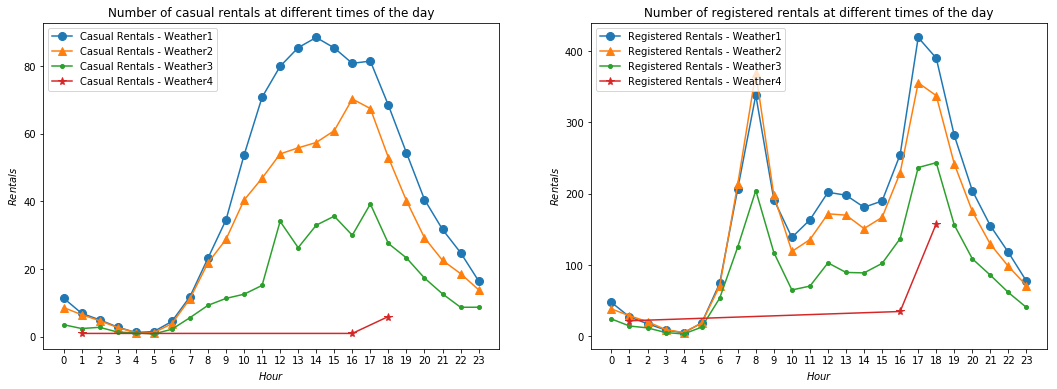

In [9]:
# your code here
'''
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm
4: Heavy Rain + Thunderstorm + Mist, Snow + Fog
'''
weather1_df = bikes_df[bikes_df['weather']==1]
weather2_df = bikes_df[bikes_df['weather']==2]
weather3_df = bikes_df[bikes_df['weather']==3]
weather4_df = bikes_df[bikes_df['weather']==4]

weather1_df_hourly = weather1_df.groupby('hour').agg({
    'casual': np.mean,
    'registered':np.mean
})
weather2_df_hourly = weather2_df.groupby('hour').agg({
    'casual': np.mean,
    'registered':np.mean
})
weather3_df_hourly = weather3_df.groupby('hour').agg({
    'casual': np.mean,
    'registered':np.mean
})
weather4_df_hourly = weather4_df.groupby('hour').agg({
    'casual': np.mean,
    'registered':np.mean
})


fig, ax = plt.subplots(1,2, figsize=(18,6))

ax[0].plot(weather1_df_hourly.index, weather1_df_hourly['casual'], 'o-', ms=8, label="Casual Rentals - Weather1")
ax[0].plot(weather2_df_hourly.index, weather2_df_hourly['casual'],'^-', ms=8, label="Casual Rentals - Weather2")
ax[0].plot(weather3_df_hourly.index, weather3_df_hourly['casual'], '.-', ms=8, label="Casual Rentals - Weather3")
ax[0].plot(weather4_df_hourly.index, weather4_df_hourly['casual'],'*-', ms=8, label="Casual Rentals - Weather4")
ax[0].set_xlabel(r'$Hour$')
ax[0].set_ylabel(r'$Rentals$')
ax[0].set_xticks(np.arange(0, 24, 1))
ax[0].set_title(r'Number of casual rentals at different times of the day')
ax[0].legend();

ax[1].plot(weather1_df_hourly.index, weather1_df_hourly['registered'], 'o-', ms=8, label="Registered Rentals - Weather1")
ax[1].plot(weather2_df_hourly.index, weather2_df_hourly['registered'],'^-', ms=8, label="Registered Rentals - Weather2")
ax[1].plot(weather3_df_hourly.index, weather3_df_hourly['registered'], '.-', ms=8, label="Registered Rentals - Weather3")
ax[1].plot(weather4_df_hourly.index, weather4_df_hourly['registered'],'*-', ms=8, label="Registered Rentals - Weather4")
ax[1].set_xlabel(r'$Hour$')
ax[1].set_ylabel(r'$Rentals$')
ax[1].set_xticks(np.arange(0, 24, 1))
ax[1].set_title(r'Number of registered rentals at different times of the day')
ax[1].legend();

<HR>
We observe that as the weather deteriorates, i.e. weather 1 to weather 4, the number of bike rentals goes down in general.
<HR>

<div class='exercise'> <b> Question 2: Explore Seasonality on Bike Ridership. </b></div>
#### Seasonality and weather

Now let's examine the effect of weather and time of the year. For example, you want to see how ridership varies with season of the year. 

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being **ONE** day:

- `dteday`, the timestamp for that day (fine to set to noon or any other time)
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals

Name this dataframe `bikes_by_day` and use it for all of Question 2.

**2.2** How does **season** affect the number of bike rentals for **casual riders** or **registered riders** per day? Use the variable `season` for this question. Comment on your observations. 

**2.3** What percentage of rentals are made by casual riders or registered riders for each day of the week? Comment on any patterns you see and give a possible explanation.

**2.4** How is the **distribution of total number of bike rentals** different for sunny days vs cloudy days?

**2.5** Visualize how the **total number of rides** per day varies with the **season**. Do you see any **outliers**? (We define an outlier as a value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. This is the same rule used by pyplot's boxplot function). If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or an important event.

#### HINT
- Use .copy() when creating the new dataframe, so you leave the original untouched. We will come back to it later.
- Use .groupby() to creat the new dataframe. You will have to make some choice on how to aggregate the variables.

### Answers

#### 2.1 Make a new dataframe with the following subset ...

In [10]:
# your code here
bikes_by_day = bikes_df.copy()

bikes_by_day['dteday'] = bikes_by_day['dteday'].values.astype(np.int64)
bikes_by_day = bikes_by_day.groupby('dteday').agg({
    'weekday': np.max,
    'weather': np.max,
    'season': np.max,
    'temp': np.average,
    'atemp': np.average,
    'windspeed': np.average,
    'hum': np.average,
    'casual': np.sum,
    'registered': np.sum,
    'counts': np.sum
})
bikes_by_day.head()


,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
1293840000000000000,6,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
1293926400000000000,0,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
1294012800000000000,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
1294099200000000000,2,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
1294185600000000000,3,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


#### 2.2 How does season affect the number of bike ...

Text(0.5,0.98,'Affects of season on number of bike rentals for casual riders or registered riders per day')

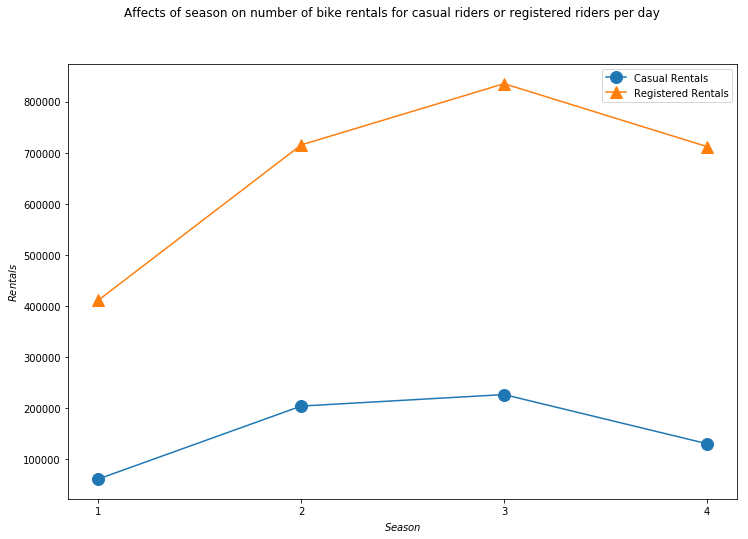

In [11]:
# your code here
'''
1 = winter, 2 = spring, 3 = summer, 4 = fall
'''
bikes_by_day_seasonal = bikes_by_day.groupby('season').agg({
    'casual': np.sum,
    'registered': np.sum
})

fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(bikes_by_day_seasonal.index, bikes_by_day_seasonal['casual'], 'o-', ms=12, label="Casual Rentals")
ax.plot(bikes_by_day_seasonal.index, bikes_by_day_seasonal['registered'],'^-', ms=12, label="Registered Rentals")
ax.set_xlabel(r'$Season$')
ax.set_ylabel(r'$Rentals$')
ax.set_xticks(np.arange(1, 5, 1))
ax.legend();
fig.suptitle('Affects of season on number of bike rentals for casual riders or registered riders per day')

<HR>
Bike rentals are the lowest in the winter, as expected. The number gradually rises as spring rolls around and peaks in the summer. It then begins to decend as fall arives.<HR>

#### 2.3 What percentage of rentals are made by casual riders or registered riders ...

In [12]:
# your code here
'''
0 through 6, with 0 denoting Sunday
'''
bikes_by_day_of_week = bikes_by_day.groupby('weekday').agg({
    'casual': np.sum,
    'registered': np.sum,
    'counts': np.sum
})
for index in bikes_by_day_of_week.index:
    print('On day: ', index)
    print('\t % of casual: {0:2.4}'.format((bikes_by_day_of_week['casual'].values[index]/bikes_by_day_of_week['counts'].values[index])*100))
    print('\t % of registered: {0:2.4}'.format((bikes_by_day_of_week['registered'].values[index]/bikes_by_day_of_week['counts'].values[index])*100))

On day:  0
	 % of casual: 31.65
	 % of registered: 68.35
On day:  1
	 % of casual: 15.54
	 % of registered: 84.46
On day:  2
	 % of casual: 12.33
	 % of registered: 87.67
On day:  3
	 % of casual: 12.12
	 % of registered: 87.88
On day:  4
	 % of casual: 12.66
	 % of registered: 87.34
On day:  5
	 % of casual: 16.04
	 % of registered: 83.96
On day:  6
	 % of casual: 32.2
	 % of registered: 67.8


<HR>
On weekends, the percentage of rentals by casual riders doubles and the number of rentals by registered riders reduces by about 20%. One possible explanation for this is that casual riders tend to rend bikes over weekends and registered riders use bike rentals for their weekly commute. <HR>

#### 2.4 How is the distribution of total number of bike rentals different ...

Text(0.5,0.98,'Distribution of total number of bike rentals for sunny days vs cloudy days')

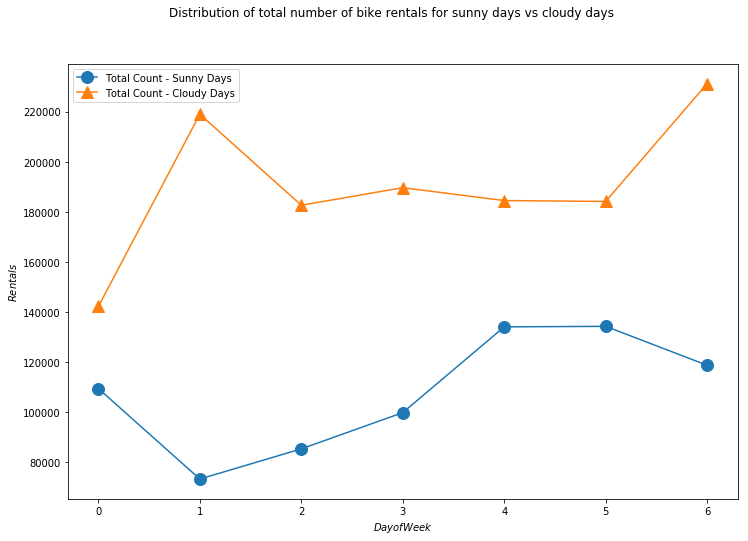

In [13]:
# your code here
'''
How is the distribution of total number of bike rentals different for sunny days vs cloudy days
Assuming:
Sunny Days -> Weather 1
Cloudy Days -> Weather 2
'''

bikes_by_day_weather1 = bikes_by_day[bikes_by_day['weather']==1]
bikes_by_day_weather2 = bikes_by_day[bikes_by_day['weather']==2]

bikes_by_dayofweek_weather1 = bikes_by_day_weather1.groupby('weekday').agg({
    'casual': np.sum,
    'registered': np.sum,
    'counts': np.sum
})

bikes_by_dayofweek_weather2 = bikes_by_day_weather2.groupby('weekday').agg({
    'casual': np.sum,
    'registered': np.sum,
    'counts': np.sum
})

fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(bikes_by_dayofweek_weather1.index, bikes_by_dayofweek_weather1['counts'], 'o-', ms=12, label="Total Count - Sunny Days")
ax.plot(bikes_by_dayofweek_weather2.index, bikes_by_dayofweek_weather2['counts'],'^-', ms=12, label="Total Count - Cloudy Days")
ax.set_xlabel(r'$Day of Week$')
ax.set_ylabel(r'$Rentals$')
ax.set_xticks(np.arange(0, 7, 1))
ax.legend();
fig.suptitle('Distribution of total number of bike rentals for sunny days vs cloudy days')

<HR>
The two distributions seem to be inverted versions of each other i.e. they follow reverse patterns.
<HR>

#### 2.5 Visualize how the total number of rides per day ...

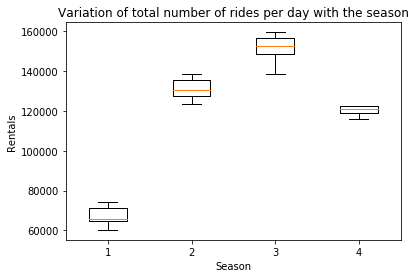

In [14]:
# your code here
'''
Visualize how the total number of rides per day varies with the season. 
Do you see any outliers? (We define an outlier as a value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. 
This is the same rule used by pyplot's boxplot function). 
If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or an important event.
'''
bikes_by_dayofweek_season1 = bikes_by_day[bikes_by_day['season']==1].groupby('weekday').agg({'counts':np.sum})
bikes_by_dayofweek_season2 = bikes_by_day[bikes_by_day['season']==2].groupby('weekday').agg({'counts':np.sum})
bikes_by_dayofweek_season3 = bikes_by_day[bikes_by_day['season']==3].groupby('weekday').agg({'counts':np.sum})
bikes_by_dayofweek_season4 = bikes_by_day[bikes_by_day['season']==4].groupby('weekday').agg({'counts':np.sum})

data = [bikes_by_dayofweek_season1['counts'], bikes_by_dayofweek_season2['counts'], bikes_by_dayofweek_season3['counts'], bikes_by_dayofweek_season4['counts']]

plt.boxplot(data)
plt.xlabel("Season")
plt.ylabel("Rentals")
plt.title("Variation of total number of rides per day with the season")
plt.show()


<HR>
No outliers were detected.<HR>

<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

**3.1** Visualize and describe inter-dependencies among the following variables: `weekday`, `season`, `month`,`weather`, `temp`, `atemp`, `hum`, `windspeed`, `casual`,`registered`, `counts`. Note and comment on any strongly related variables.

**3.2** Convert the categorical attributes into multiple binary attributes using **one-hot encoding**. 


**3.3** Split the initial `bikes_df` dataset (with hourly data about rentals) into train and test sets. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. We ask you to create your train and test sets, but for consistency and easy checking we ask that, for the rest of this problem set, you use the train and test set provided in the question below.

**3.4** Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively. After checking your train and test datasets for accuracy, remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis. Also, remove any predictors that would make predicting the `count` trivial.

**3.5** Calculate the **Pearson correlation** coefficients between all the features. Visualize the matrix using a heatmap. Which predictors have a positive correlation with the number of bike rentals? For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Identify pairs of predictors with collinearity >0.7.

#### Hints: 
- You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.



#### Answers

#### 3.1 Visualize and describe inter-dependencies  ... 

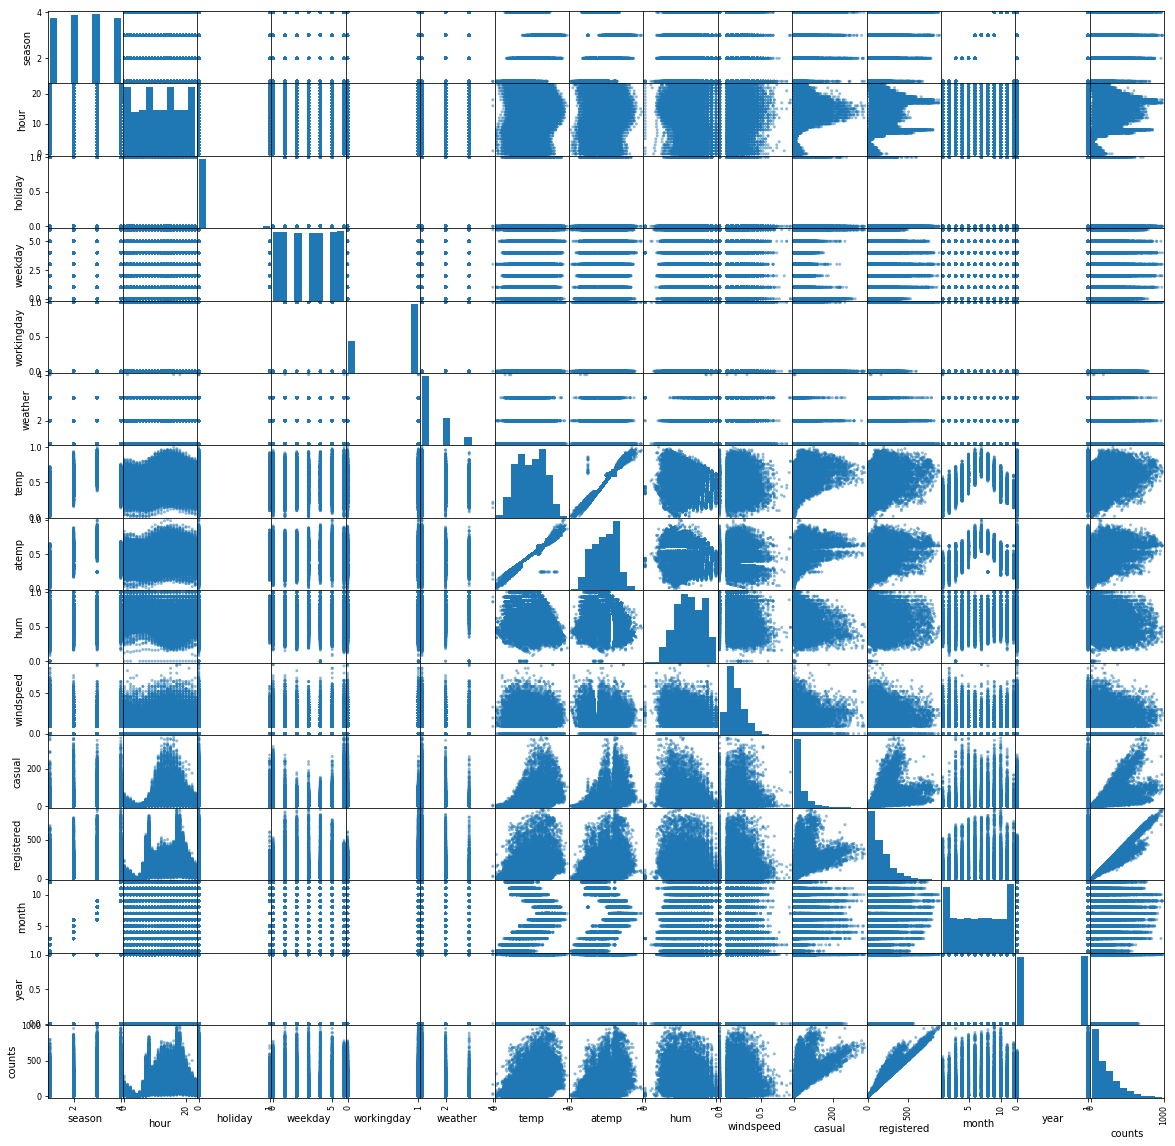

In [15]:
# your code here
scatter_matrix(bikes_df, figsize=(20,20));

<HR>
1. temp and atemp are obviously strongly related.  <BR>
2. registered and counts are strongly related.
<HR>

#### 3.2 Convert the categorical attributes  ....

In [16]:
# your code here
'''
Categorical variables: 
season (1 = winter, 2 = spring, 3 = summer, 4 = fall)    -> Convert
weekday (0 through 6, with 0 denoting Sunday)            -> Convert
holiday (1 = the day is a holiday, 0 = otherwise)        -> No need to convert
weather                                                  -> Convert
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm
4: Heavy Rain + Thunderstorm + Mist, Snow + Fog
'''
bikes_df_cat = bikes_df.copy()

bikes_df_cat['season_cat_1'] = np.where(bikes_df_cat['season']==1, 1, 0)
bikes_df_cat['season_cat_2'] = np.where(bikes_df_cat['season']==2, 1, 0)
bikes_df_cat['season_cat_3'] = np.where(bikes_df_cat['season']==3, 1, 0)
bikes_df_cat['season_cat_4'] = np.where(bikes_df_cat['season']==4, 1, 0)

bikes_df_cat['weekday_cat_1'] = np.where(bikes_df_cat['weekday']==0, 1, 0)
bikes_df_cat['weekday_cat_2'] = np.where(bikes_df_cat['weekday']==1, 1, 0)
bikes_df_cat['weekday_cat_3'] = np.where(bikes_df_cat['weekday']==2, 1, 0)
bikes_df_cat['weekday_cat_4'] = np.where(bikes_df_cat['weekday']==3, 1, 0)
bikes_df_cat['weekday_cat_5'] = np.where(bikes_df_cat['weekday']==4, 1, 0)
bikes_df_cat['weekday_cat_6'] = np.where(bikes_df_cat['weekday']==5, 1, 0)
bikes_df_cat['weekday_cat_7'] = np.where(bikes_df_cat['weekday']==6, 1, 0)

bikes_df_cat['weather_cat_1'] = np.where(bikes_df_cat['weather']==1, 1, 0)
bikes_df_cat['weather_cat_2'] = np.where(bikes_df_cat['weather']==2, 1, 0)
bikes_df_cat['weather_cat_3'] = np.where(bikes_df_cat['weather']==3, 1, 0)
bikes_df_cat['weather_cat_4'] = np.where(bikes_df_cat['weather']==4, 1, 0)

bikes_df_cat = bikes_df_cat.drop(['season', 'weekday', 'weather'], axis=1)

#### 3.3 Split the initial bikes_df dataset...

In [17]:
# your code here
'''
For a large enough data set, 2000 observations in test suffice. Going beyond that doesn't really add much value.
'''
print('Number of observations: {0}'.format(len(bikes_df)))
print('% for 2000 test observations: {0}'.format(2000*100/len(bikes_df)))
print('We use this in our train_test_split')
train_data, test_data = train_test_split(bikes_df, test_size = 0.12, stratify=bikes_df['month'])

Number of observations: 17379
% for 2000 test observations: 11.50814201047241
We use this in our train_test_split


#### 3.4  Read `data/BSS_train.csv` and `data/BSS_test.csv` into ...

In [18]:
# your code here
'''
Read data/BSS_train.csv and data/BSS_test.csv into dataframes BSS_train and BSS_test, respectively.
After checking your train and test datasets for accuracy, remove the dteday column from both train and test dataset.
We do not need it, and its format cannot be used for analysis. 
Also, remove any predictors that would make predicting the count trivial.
'''
BSS_train = pd.read_csv("data/BSS_train.csv", index_col=0)
BSS_test = pd.read_csv("data/BSS_test.csv", index_col=0)

BSS_train = BSS_train.drop(['dteday','year','casual','registered'], axis=1)
BSS_test = BSS_test.drop(['dteday','year','casual','registered'], axis=1)

<HR>
Index column is present in the dataset so read it accordingly. <BR>
<HR>

<HR>
Registered and casual could be considered trivial to the prediction of counts since it is basically summing up these two. Years also seems trivial.<HR>

#### 3.5 Calculate the **Pearson correlation** ....

Number of features in BSS_train:  31
Shape of Pearson correlation matrix:  (31, 31)


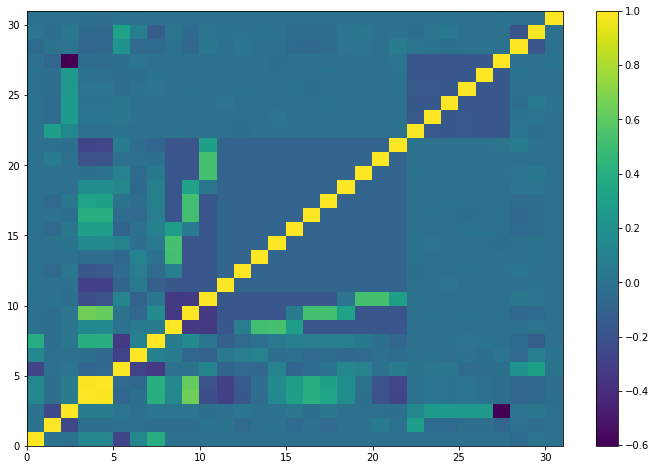

In [19]:
# your code here
print('Number of features in BSS_train: ', len(BSS_train.columns))
pearson_cor = np.corrcoef(BSS_train.T)
print('Shape of Pearson correlation matrix: ', pearson_cor.shape)

fig, ax = plt.subplots(1,1, figsize=(12,8))
plt.pcolor(pearson_cor)
plt.colorbar()

In [20]:
# Select the row for counts since we want to get correlation for the features with counts
count_row = pearson_cor[10,:]

# Get the index of all features with positive correlation
positiveitemindex = np.where(count_row > 0)[0]
# Translate the index value to the column name
columns = []
for index in positiveitemindex:
    columns.append(BSS_train.iloc[:, [index]].columns[0])
columns.remove('counts')
print('The columns that have a positive correlation with the number of bike rentals are: ', columns)


The columns that have a positive correlation with the number of bike rentals are:  ['holiday', 'hum', 'fall', 'Sept', 'Oct', 'Nov', 'Dec', 'Tue', 'Thu', 'Sat', 'Cloudy', 'Snow']


In [21]:
a, b = np.where(pearson_cor > 0.7 )
# Create matrix of indices
matrix = np.array(list(zip(a,b)))
# Select the ones where indices are different i.e. not correlated with itself
itemindex = np.where(np.equal(matrix[:,0], matrix[:,1]) == False)[0]
interest_indices = []
for item in itemindex:
    interest_indices.append(matrix[item])
# Translate the indices to column names
interest_relations = []
for interest_index in interest_indices:
    interest_relations.append([BSS_train.iloc[:, [interest_index[0]]].columns[0], BSS_train.iloc[:, [interest_index[1]]].columns[0]])
print('Pairs of predictors with collinearity >0.7 : ',interest_relations)

Pairs of predictors with collinearity >0.7 :  [['temp', 'atemp'], ['atemp', 'temp']]


<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms), and report its $R^2$ score on the train and test sets.


**4.2** Find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value < 0.05). Comment on the results.


**4.3** Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is slightly different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms? 

### Answers
#### 4.1 Use statsmodels to fit a ... 


In [22]:
# your code here
X_train = sm.add_constant(BSS_train.drop(['counts'], axis=1))
y_train = BSS_train['counts']
X_test = sm.add_constant(BSS_test.drop(['counts'], axis=1))
y_test = BSS_test['counts']

fitted_sm_ols = OLS(endog=y_train, exog=X_train).fit()
y_train_pred = fitted_sm_ols.predict(X_train)
y_test_pred = fitted_sm_ols.predict(X_test)

print("Train R-squared: {0:6.4}".format(fitted_sm_ols.rsquared))

y_test_arr = y_test.values.flatten()
y_predict_test_arr = y_test_pred.values.flatten()
y_mean = np.mean(y_test)

numerator = 0
denominator =0
for i in range(len(y_test_arr)):
    numerator += (y_predict_test_arr[i]-y_test_arr[i])*(y_predict_test_arr[i]-y_test_arr[i])
    denominator += (y_mean-y_test_arr[i])*(y_mean-y_test_arr[i])

R_squared_test = 1-(numerator/denominator)
print("Test R-squared: {0:6.4}".format(R_squared_test))

fitted_sm_ols.summary()

Train R-squared: 0.3625
Test R-squared:  0.354


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     272.0
Date:                Tue, 17 Jul 2018   Prob (F-statistic):               0.00
Time:                        20:32:38   Log-Likelihood:                -88804.
No. Observations:               13903   AIC:                         1.777e+05
Df Residuals:                   13873   BIC:                         1.779e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.7713      8.803      3.382      0.001      12.515      47.027
hour           6.8941      0.191     36.113      0.000       6.520       7.268
holiday      -18.0549      6.837     -2.641      0.008     -31.457      -4.653
workingday    10.3639      2.851      3.635      0.000       4.776      15.952
temp         382.9725     45.742      8.373      0.000     293.313     472.632
atemp         60.9596     47.886      1.273      0.203     -32.904     154.824
hum         -226.1822      8.057    -28.073      0.000    -241.975    -210.389
windspeed      8.7508     11.136      0.786      0.432     -13.077      30.578
spring        46.0540      7.687      5.991      0.000      30.987      61.121
summer        28.6217      9.093      3.148      0.002      10.799      46.444
fall          66.4476      7.764      8.559      0.000      51.229      81.666
Feb          -11.0572      6.182     -1.789      0.074     -23.174       1.060
Mar          -20.1046      6.902     -2.913      0.004     -33.633      -6.576
Apr          -54.8396     10.228     -5.362      0.000     -74.888     -34.791
May          -50.3313     10.913     -4.612      0.000     -71.721     -28.941
Jun          -86.5310     11.086     -7.805      0.000    -108.261     -64.801
Jul         -113.1817     12.510     -9.047      0.000    -137.703     -88.660
Aug          -77.5771     12.249     -6.334      0.000    -101.586     -53.568
Sept         -28.9347     10.952     -2.642      0.008     -50.402      -7.468
Oct          -25.6482     10.220     -2.510      0.012     -45.680      -5.616
Nov          -29.8654      9.873     -3.025      0.002     -49.218     -10.513
Dec          -12.7773      7.890     -1.619      0.105     -28.243       2.689
Mon           -2.5827      3.087     -0.837      0.403      -8.633       3.467
Tue           -6.5175      3.324     -1.961      0.050     -13.033      -0.001
Wed            2.4441      3.299      0.741      0.459      -4.022       8.910
Thu           -3.5289      3.301     -1.069      0.285      -9.999       2.941
Fri            2.4939      3.302      0.755      0.450      -3.978       8.965
Sat           13.2741      4.541      2.923      0.003       4.373      22.175
Cloudy         9.5809      3.004      3.190      0.001       3.693      15.469
Snow         -27.0621      4.994     -5.419      0.000     -36.851     -17.273
Storm         49.1380    101.958      0.482      0.630    -150.713     248.989
==============================================================================
Omnibus:                     3457.396   Durbin-Watson:                   0.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8105.093
Skew:                           1.397   Prob(JB):                         0.00
Kurtosis:                       5.486   Cond. No.                     1.17e+16
==

#### 4.2 Find out which of estimated coefficients ...

<HR>
Checking for p-value < 0.05, following variables are insignificant: <BR>
&nbsp;atemp
&nbsp;windspeed
&nbsp;Feb
&nbsp;Dec
&nbsp;Wed
&nbsp;Thu
&nbsp;Fri
<BR> <BR>
Some of these exclusions seem strage, but that's probably because of multi-collinearity.
<HR>

#### 4.3 Make a plot of residuals of the fitted ...

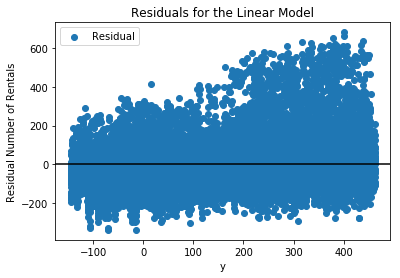

In [23]:
# your code here
design_mat = X_train

prediction = fitted_sm_ols.predict(design_mat)
residual = y_train - prediction
xgrid = np.linspace(prediction.min(), prediction.max(), len(prediction))

plt.scatter(xgrid, residual, label="Residual")
plt.axhline(0, color='k')

plt.title("Residuals for the Linear Model")
plt.ylabel("Residual Number of Rentals")
plt.xlabel(r'y')
plt.legend()


<HR>
The plot reveals a non-linear relationship between the predictors and response.<BR>
The errors don't seem to have a constant variance.
<HR>

<div class='exercise'> <b>Question 5: Subset Selection </b> </div>

**5.1** Implement forward step-wise  selection to select a minimal subset of predictors that are related to the response variable: 

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. 

**5.2** Do these methods eliminate one or more of the colinear predictors (if any) identified in Question 3.5?  If so, which ones. Briefly explain (3 or fewer sentences) why you think this may be the case.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Question 4 using all predictors?

### Answers

#### 5.1  Implement forward step-wise ....

In [24]:
# your code here
import statsmodels.formula.api as smf

def forward_selected(data, response,):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by BIC
    """
    columns = set(data.columns)
    columns.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while columns and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in columns:
            formula = "{} ~ {} + 1".format(response,' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().bic
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if (current_score == 0.0 or current_score > best_new_score):
            columns.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [25]:
forward_step_model = forward_selected(BSS_train, 'counts', )

print(forward_step_model.model.formula)

counts ~ temp + hour + hum + fall + Jul + Snow + Aug + Jun + holiday + Cloudy + 1


<HR>
counts ~ temp + hour + hum + fall + Jul + Snow + Aug + Jun + holiday + Cloudy + 1
<HR>

#### 5.2 Do these methods eliminate ...

<HR>
Yes, it eliminates temp's collinear predictor 'atemp' as it considers to be redundant.
<HR>

#### 5.3 In each case, fit linear regression  ...

In [26]:
# your code here
print("Train R-squared: {0:6.4}".format(forward_step_model.rsquared))

y_train_pred = forward_step_model.predict(X_train)
y_test_pred = forward_step_model.predict(X_test)

y_test_arr = y_test.values.flatten()
y_predict_test_arr = y_test_pred.values.flatten()
y_mean = np.mean(y_test)

numerator = 0
denominator =0
for i in range(len(y_test_arr)):
    numerator += (y_predict_test_arr[i]-y_test_arr[i])*(y_predict_test_arr[i]-y_test_arr[i])
    denominator += (y_mean-y_test_arr[i])*(y_mean-y_test_arr[i])

R_squared_test = 1-(numerator/denominator)
print("Test R-squared: {0:6.4}".format(R_squared_test))

Train R-squared: 0.3597
Test R-squared: 0.3528


<HR>
$R^2$ values for the fitted models are slightly lower than the model fitted in Question 4 using all predictors.
<HR>

<div class='exercise'> <b> Question 6: Polynomial Regression </b> </div> 

We will now try to improve the performance of the regression model by including higher-order polynomial terms. 

**6.1** For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a polynomial regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in the previous question? Using a $t$-tests, find out which of the estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
# your code here
'''
Continuous predictors: 
temp, atemp, humidity, windspeed
'''
def build_model_design_mat(df):
    
    df_copy = df.copy()
    continuous_cols = ['temp', 'atemp', 'humidity', 'windspeed']
    for x in df_copy.columns:
        if x in continuous_cols:
            temp = x
            df_copy[temp+'_sqrd'] = df_copy[x]**2
            df_copy[temp+'_cube'] = df_copy[x]**3
            df_copy[temp+'_quad'] = df_copy[x]**4

    return df_copy

X_train_copy = build_model_design_mat(X_train)
X_test_copy = build_model_design_mat(X_test)

sk_fitted_model = LinearRegression().fit(X_train_copy, y_train)
print('R squared on test set: {0:6.4}'.format(sk_fitted_model.score(X_test_copy, y_test)))

R squared on test set: 0.3651


In [29]:
coeff = sk_fitted_model.coef_

insignificant_coeff_indices = np.where(coeff<0)[0]
insignificant_coeff = X_train_copy.columns[insignificant_coeff_indices]
print('Insignificant coefficients are: ', insignificant_coeff)

Insignificant coefficients are:  Index(['holiday', 'hum', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Mon', 'Tue', 'Thu', 'Snow', 'temp_sqrd',
       'temp_quad', 'atemp_sqrd', 'atemp_quad', 'windspeed_cube'],
      dtype='object')


<HR>
R squared on test set: 0.3651 <BR><BR>
Insignificant coefficients are: <BR>'holiday', 'hum', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sept', 'Oct', 'Nov', 'Mon', 'Tue', 'Thu', 'Snow', 'temp_sqrd',
       'temp_quad', 'atemp_sqrd', 'atemp_quad', 'windspeed_cube'
<HR>

#  Written Report to the Administrators
<br>

<div class='exercise'> <b> Question 7 </b> </div>

Write a short summary report, intended for the administrators of the company, to address two major points (can be written as two large paragraphs):

1. How to predict ridership well (which variables are important, when is ridership highest/lowest, etc.).

2. Suggestions on how to increase the system revenue (what additional services to provide, when to give discounts, etc.).
 
Include your report below. The report should not be longer than 300 words and should include a maximum of 3 figures. 

### Answers
<HR>
#### 1. How to predict ridership well (which variables are important, when is ridership highest/lowest, etc.).

Time of day:<BR>
This is a variable with a very defined pattern. Peak morning and evening hours show a surge in rentals on weekdays. 

Season:<BR>
Spring and summer rentals are at least twice the number of winter rentals. Fall rentals are almost twice as high as winter rentals. 

Temperature:<BR>
Temperature has a quadratic relation with the count. Number of rentals is low at low  and high temperatures. It gradually increases to a peak in between and drops back off.

Weather:<BR>
Sunny and low humidity weather is ideal for high number of rentals.
<HR>

#### 2. Suggestions on how to increase the system revenue (what additional services to provide, when to give discounts, etc.).

a. Offer a lower pricing model at nights and during the day. Maybe something like half price from 11pm to 6am.<BR>
b. Reduce number of dispatched bikes in the winter to lower maintenance cost.<BR>
c. Run promotions on days of high temperature and humidity.<BR>
d. Introduce surge pricing for ideal days i.e. perfect temperature, low humidity on a weekend in the summer.